# Examples

The following examples shall help to understand what the package is able to accomplish and how you can use the interface *yeoda* offers to access and play around with your data.

## Setting up a datacube

A *yeoda* datacube augments existing data by integrating it into a datacube architecture similar to, e.g. [Open Data Cube](https://www.opendatacube.org/about). To set up such a datacube *yeoda* works in concert with [geopathfinder](https://github.com/TUW-GEO/geopathfinder) (file naming), [veranda](https://github.com/TUW-GEO/veranda) (IO classes) and [pytiletproj/Equi7Grid](https://github.com/TUW-GEO/Equi7Grid) (geo-referencing).

First collect the files you want to put into your datacube. You can use [geopathfinder](https://github.com/TUW-GEO/geopathfinder) to conveniently gather files matching a certain file naming convention:

In [1]:
from geopathfinder.folder_naming import build_smarttree

root_path = "/data/Sentinel-1_CSAR/MMEAN_SIG0/"
folder_hierarchy = ["data_version", "subgrid_name", "tile_name"]

# regex expressions are supported to select only files matching a certain pattern
# (i.e. not starting with Q ending with .tif)
tree = build_smarttree(root_path, folder_hierarchy, register_file_pattern="^[^Q].*.tif$")
filepaths = tree.file_register

print(f"{len(filepaths)} files registered:")
print("\n".join(filepaths))

4 files registered:
/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_EU500M/E048N012T6/SIG0-MAG-MEAN_20190201T050943_20190228T164051_VH_IWGRDH1_E048N012T6_EU500M_V0M1R1_S1.tif
/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_EU500M/E048N012T6/SIG0-MAG-MEAN_20190201T050943_20190228T164051_VV_IWGRDH1_E048N012T6_EU500M_V0M1R1_S1.tif
/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_EU500M/E048N012T6/SIG0-MAG-MEAN_20190301T052548_20190305T164921_VH_IWGRDH1_E048N012T6_EU500M_V0M1R1_S1.tif
/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_EU500M/E048N012T6/SIG0-MAG-MEAN_20190301T052548_20190328T165746_VV_IWGRDH1_E048N012T6_EU500M_V0M1R1_S1.tif


You can use [pytiletproj/Equi7Grid](https://github.com/TUW-GEO/Equi7Grid) to define a grid to be used by the datacube.

In [2]:
from equi7grid.equi7grid import Equi7Grid

subgrid = Equi7Grid(500).EU

The file registry and grid can now be used directly as input to *yeoda's* `EODataCube` constructor, to wrap a datacube structure around our files.

In [3]:
from geopathfinder.naming_conventions.yeoda_naming import YeodaFilename
from yeoda.datacube import EODataCube

dimensions = ["var_name", "datetime_1", "datetime_2", "band", "tile_name"]
sig0_cube = EODataCube(filepaths=filepaths, dimensions=dimensions, filename_class=YeodaFilename, grid=subgrid,
                       sdim_name="tile_name", tdim_name="datetime_1")
sig0_cube.inventory

,filepath,var_name,datetime_1,datetime_2,band,tile_name
0,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VH,E048N012T6
1,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VV,E048N012T6
2,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-03-01 05:25:48,2019-03-05 16:49:21,VH,E048N012T6
3,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-03-01 05:25:48,2019-03-28 16:57:46,VV,E048N012T6


Now you're all setup and can perform operations on your freshly minted datacube. Internally, *yeoda* uses a [GeoPandas](https://geopandas.org) dataframe to store the filename and geometry information.  On top of that, datacube functions were defined to filter, split, sort, align, etc. the data. It has to be noted that most functions have a keyword argument `inplace`, same as most [GeoPandas](https://geopandas.org) functions. In the next sections some example usages of these functions will be shown.

This example showcases the most generic flavour of a datacube, however there are also more specialized data cube classes available, which have been developed at the research group Remote Sensing of the GEO Department at TU Wien (TUWGEO). See the next section.

### Setting up product specific datacubes

To work with preprocessed data you can use the classes `SIG0DataCube` for sigma nought and `GMRDataCube` for radiometric terrain flattened gamma nought data. On the value-added data side, `SSMDataCube` allows you to access the TUWGEO SSM data, and `SCATSARSWIDataCube` SWI data respectively.

In [4]:
from geopathfinder.naming_conventions.sgrt_naming import SgrtFilename
from yeoda.products.scatsar_swi import SCATSARSWIDataCube

root_path = "/data/SCATSAR_SWI"
folder_hierarchy = ["subgrid_name", "tile_name", "var_name"]
# this time we want NetCDF files
tree = build_smarttree(root_path, folder_hierarchy, register_file_pattern="^[^Q].*.nc$")

dimensions = ["time", "var_name", "tile_name"]
swi_cube = SCATSARSWIDataCube(filepaths=tree.file_register, dimensions=dimensions, filename_class=SgrtFilename,
                              grid=subgrid)
swi_cube.inventory.head()

,filepath,time,var_name,tile_name
0,/data/SCATSAR_SWI/EQUI7_EU500M/E048N012T6/swi/...,2019-01-01 12:00:00,SWI,E048N012T6
1,/data/SCATSAR_SWI/EQUI7_EU500M/E048N012T6/swi/...,2019-01-02 12:00:00,SWI,E048N012T6
2,/data/SCATSAR_SWI/EQUI7_EU500M/E048N012T6/swi/...,2019-01-03 12:00:00,SWI,E048N012T6
3,/data/SCATSAR_SWI/EQUI7_EU500M/E048N012T6/swi/...,2019-01-04 12:00:00,SWI,E048N012T6
4,/data/SCATSAR_SWI/EQUI7_EU500M/E048N012T6/swi/...,2019-01-05 12:00:00,SWI,E048N012T6


Note, that *yeoda* is not limited to GeoTIFF files, it also supports NetCDF files.

## Dimension operations

The following sections shows how you can manipulate the dimensions of the datacube itself, before doing any further operations based on them.

### Renaming dimensions

If you have to work with a pre-defined naming convention in geopathfinder (e.g. the *yeoda* naming convention) and if you do not agree with the naming of the filename parts/dimensions, you can still rename dimensions afterwards:

In [5]:
sig0_cube.rename_dimensions({'tile_name': 'tile'}, inplace=True)
sig0_cube.inventory

,filepath,var_name,datetime_1,datetime_2,band,tile
0,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VH,E048N012T6
1,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VV,E048N012T6
2,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-03-01 05:25:48,2019-03-05 16:49:21,VH,E048N012T6
3,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-03-01 05:25:48,2019-03-28 16:57:46,VV,E048N012T6


### Adding dimensions

You can simply add new filepath-dependent values (e.g. file size, cloud coverage, …) along a new dimension (e.g. named “new_dimension”) with a few lines of code:

In [6]:
extended = sig0_cube.add_dimension("ones", [1] * len(sig0_cube))
extended.inventory

,filepath,var_name,datetime_1,datetime_2,band,tile,ones
0,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VH,E048N012T6,1
1,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VV,E048N012T6,1
2,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-03-01 05:25:48,2019-03-05 16:49:21,VH,E048N012T6,1
3,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-03-01 05:25:48,2019-03-28 16:57:46,VV,E048N012T6,1


## Sorting

One of the most common operations is to sort the inventory according to some metadata, e.g. the timestamp:

In [7]:
sorted_descending = sig0_cube.sort_by_dimension('datetime_1', ascending=False)
sorted_descending.inventory

,filepath,var_name,datetime_1,datetime_2,band,tile
2,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-03-01 05:25:48,2019-03-05 16:49:21,VH,E048N012T6
3,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-03-01 05:25:48,2019-03-28 16:57:46,VV,E048N012T6
0,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VH,E048N012T6
1,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VV,E048N012T6


## Filtering

Once you have your datacube structure setup you can also filter it before doing any processing. For instance, if you want to do some runtime intensive processing on only a small portion of the data. The following sections give a few examples of the available filtering methods. Again most methods provide a `inplace` flag, similar to [GeoPandas](https://geopandas.org).

### Filter by geometry

You can filter for arbitrary geometry or a list of bounding box coordinates. The filtered cube will only contain files within the specified geometry.

In [8]:
import osr

sref = osr.SpatialReference()
sref.ImportFromEPSG(4326)  # LonLat spatial reference system

bbox_inside = [(12.628, 46.385), (15.768, 48.431)]  # [(x_min, y_min), (x_max, y_max)]
filtered_by_bbox = sig0_cube.filter_spatially_by_geom(bbox_inside, sref=sref)
print(f"Number of filtered files with a bbox located inside the data tiles: {len(filtered_by_bbox)}")

bbox_outside = [(4.404, 44.443), (8.826, 47.811)]
filtered_by_bbox = sig0_cube.filter_spatially_by_geom(bbox_outside, sref=sref)
print(f"Number of filtered files with a bbox located outside the data tiles: {len(filtered_by_bbox)}")

Number of filtered files with a bbox located inside the data tiles: 4
Number of filtered files with a bbox located outside the data tiles: 0


### Filter by dimension

A very important function is `filter_by_dimension`, which accepts a list of values and expressions to filter the data along a dimension. The list of `expressions` has the same length as the values list and includes mathematical comparison operators, e.g. “==”, “<=”, “>=”, “<”, “>” (“==” is default). Some examples are:

In [9]:
# only consider VV polarisation
only_vv = sig0_cube.filter_by_dimension(['VV'], name="band")
only_vv.inventory

,filepath,var_name,datetime_1,datetime_2,band,tile
0,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-03-01 05:25:48,2019-03-28 16:57:46,VV,E048N012T6
1,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VV,E048N012T6


In [10]:
from datetime import datetime

# only consider data between 2019-02-01 and 2019-03-01
time_span = [(datetime(2019, 2, 1), datetime(2019, 3, 1))]
time_span_only = sig0_cube.filter_by_dimension(time_span, [('>=', '<')], name='datetime_1')
time_span_only.inventory

,filepath,var_name,datetime_1,datetime_2,band,tile
0,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VH,E048N012T6
1,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VV,E048N012T6


### Filter by file pattern

You can also directly filter on the filename using a regex pattern:

In [11]:
filtered_by_pattern = sig0_cube.filter_files_with_pattern(".*T050943.*")
filtered_by_pattern.inventory

,filepath,var_name,datetime_1,datetime_2,band,tile
0,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VH,E048N012T6
1,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VV,E048N012T6


### Filter by metadata

If you have stored metadata attributes in you NetCDF or GeoTIFF files, you can also filter the datacube by certain attributes.

In [12]:
filtered_by_meta = sig0_cube.filter_by_metadata({'band': 'VH'})
filtered_by_meta.inventory

,filepath,var_name,datetime_1,datetime_2,band,tile
2,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-03-01 05:25:48,2019-03-05 16:49:21,VH,E048N012T6
0,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VH,E048N012T6


## Splitting

You can use split operations to segregate your datacube into chunks, which can then be used for processing. For instance, you could split data into months and calculate monthly means.

### Split by dimension

Split a datacube based on dimension values. The splitting conditions are expressed the same way as in `filter_by_dimension`.

In [13]:
values = ['VV', 'VH']
vv_cube, vh_cube = sig0_cube.split_by_dimension(values, name="band")
print(f"Parent datacube of length {len(sig0_cube)}, split into two datacubes of length {len(vv_cube)} and {len(vh_cube)}.")

Parent datacube of length 4, split into two datacubes of length 2 and 2.


### Split monthly
If you want to analyse your data under certain temporal aspects, in this case in a monthly manner, you can split up the original data cube into smaller monthly data cubes (if the data covers more than a month):

In [14]:
months = sig0_cube.split_monthly()
print(f"Parent datacube has been split into {len(months)} monthly datacubes:")
print("\n".join([str(cube[cube.tdim_name].iloc[0]) for cube in months]))

Parent datacube has been split into 2 monthly datacubes:
2019-02-01 05:09:43
2019-03-01 05:25:48


Note, that *yeoda* also provides convenience functions for yearly splits.

## Joining

If you have multiple datacubes, or have split them up to perform some processing, you can concatenate them using join operations. The following section will look closer at a few of them.

### Intersection

You can use this operation to get only those fields of multiple datacubes with matching dimensions or with a specific matching dimension:

In [15]:
only_february_remains = sig0_cube.intersect(months[0], on_dimension='datetime_1')
only_february_remains.inventory

,filepath,var_name,datetime_1,datetime_2,band,tile
0,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VH,E048N012T6
1,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VV,E048N012T6


### Union
If you have two data cubes and you want to unite their information, you can simply do:

In [16]:
feb_and_mar = months[0].unite(months[1])
feb_and_mar.inventory

,filepath,var_name,datetime_1,datetime_2,band,tile
0,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VH,E048N012T6
1,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VV,E048N012T6
2,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-03-01 05:25:48,2019-03-05 16:49:21,VH,E048N012T6
3,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-03-01 05:25:48,2019-03-28 16:57:46,VV,E048N012T6


### Alignment

The `align_dimension` method aligns a datacube with respect to a second datacube along a dimension (`name`). In other words, the order and the length of the dimension will then be the same. This also means that datacube entries are duplicated if they appear more often in the second datacube.

In [17]:
# create a small test datacube
small = sig0_cube.filter_by_dimension(datetime(2019, 2, 1, 5, 9, 43), name='datetime_1')
print(f"Small datacube of length {len(small)}")
# align the 'band' dimension with the large datacube
aligned_with_duplicates = small.align_dimension(sig0_cube, 'band')
aligned_with_duplicates.inventory

Small datacube of length 2


,filepath,var_name,datetime_1,datetime_2,band,tile
0,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VH,E048N012T6
1,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VV,E048N012T6
2,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VH,E048N012T6
3,/data/Sentinel-1_CSAR/MMEAN_SIG0/V0M1R1/EQUI7_...,SIG0-MAG-MEAN,2019-02-01 05:09:43,2019-02-28 16:40:51,VV,E048N012T6


## Loading Data

This section demonstrates how to load data. All functions have a common set of keyword arguments, where the most important ones are discussed here:

 - band: This argument specifies the band name as a string.
 - dtype: There are many types of Python data structures to store array-like data, and their selection mainly depends on what you want to do with the loaded data later on. These are offered by *yeoda*:
   - xarray.DataSet (“xarray”)
   - numpy.ndarray (“numpy”)
   - pandas.DataFrame (“dataframe”)
 - origin: Depending on the chosen return data type, this parameter defines the origin of the pixel coordinates in the world system. The origin can be one of the following:
   - upper right (“ur”, default)
   - upper left (“ul”)
   - lower right (“lr”)
   - lower left (“ll”)
   - center ("c")

### Load by geometry

You can load data for a region defined by an arbitrary geometry, similar to how you can filter by geometry. Geometries do not need to be axis-parallel, but data for the spanning axis aligned bounding box will be loaded nonetheless, to fit into an array data-structure. However, it is possible to mask any data outside the specified geometry by setting the `apply_mask` parameter to true.

/home/braml/miniconda3/envs/yeoda/lib/python3.7/site-packages/geospade/crs.py:527: UserWarning: Conversion from 'PROJ4' to 'EPSG' is not possible.
  warnings.warn(warn_msg.format(self._sref_type.upper(), tar_sref_type.upper()))


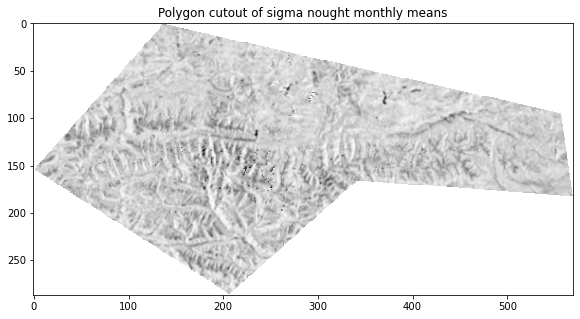

In [18]:
import matplotlib.pyplot as plt

polygon = [(12.7878,46.5504), (11.3156,46.9843), (12.0439,47.7643),
           (14.9004,47.6197), (15.0502,47.2271), (13.5471,47.1703)]
february_vv = months[0].filter_by_dimension(['VV'], name="band")
masked_xarray = february_vv.load_by_geom(polygon, sref=sref, apply_mask=True)

plt.figure(figsize=(15, 5))
plt.title("Polygon cutout of sigma nought monthly means")
# the '1' indices the first band in our monlth means backscatter GeoTIFF files
plt.imshow(masked_xarray['1'].data[0, ...], cmap=plt.cm.Greys_r)

The `masked_xarray` varialbe is an [xarray](https://docs.xarray.dev/en/stable/) with a data variable *“1”* and three dimensions *“time”*, *“x”* and *“y”*, where all spatial coordinates refer to the center pixel origin. You can perform any xarray operations on it, e.g. `.mean()` to calculate means, etc. The actual data is stored as a [masked NumPy array](https://numpy.org/doc/stable/reference/maskedarray.generic.html). It still contains all information, but has a mask allowing to mask pixels outside the geometry.

### Load by coordinates

The `load_by_coords`, accepts a list of X and a list of Y (world system) coordinates as input. If the spatial reference of the coordinates is not equal to the data, you need to specify the spatial reference keyword argument `sref`.

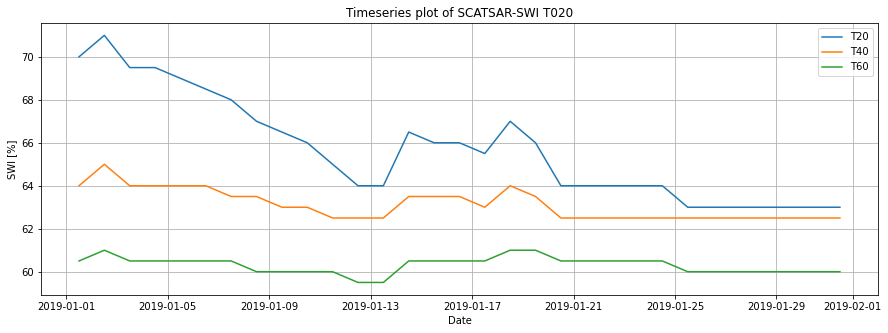

In [19]:
import ogr

# defining a point to sample a time series from
point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(16.819156,49.032356)
point.AssignSpatialReference(sref)


# load data by coordinates
data_swi_t20 = swi_cube.load_by_coords(point.GetX(), point.GetY(), band='SWI_T020', sref=sref, dtype='numpy')
data_swi_t40 = swi_cube.load_by_coords(point.GetX(), point.GetY(), band='SWI_T040', sref=sref, dtype='numpy')
data_swi_t60 = swi_cube.load_by_coords(point.GetX(), point.GetY(), band='SWI_T060', sref=sref, dtype='numpy')

# prepare a nice plot
plt.figure(figsize=(15, 5))
plt.title('Timeseries plot of SCATSAR-SWI T020')
plt.plot(swi_cube['time'], data_swi_t20.flatten(), label='T20')
plt.plot(swi_cube['time'], data_swi_t40.flatten(), label='T40')
plt.plot(swi_cube['time'], data_swi_t60.flatten(), label='T60')
plt.xlabel('Date')
plt.ylabel('SWI [%]')
plt.grid()
plt.legend()
plt.show()

By specifying the `dtype` to be `"numpy"` parameter of the loading function, we request a plain *NumPy* array instead of the default *xarray*.

### Load by pixels

`load_by_pixels` expects pixel coordinates given by a list of row and column indexes. The keyword arguments `row_size` and `col_size` allow you to define a window, where the specified ranges count from left to right (columns) and from top to bottom (rows) starting at the given row and column coordinates.

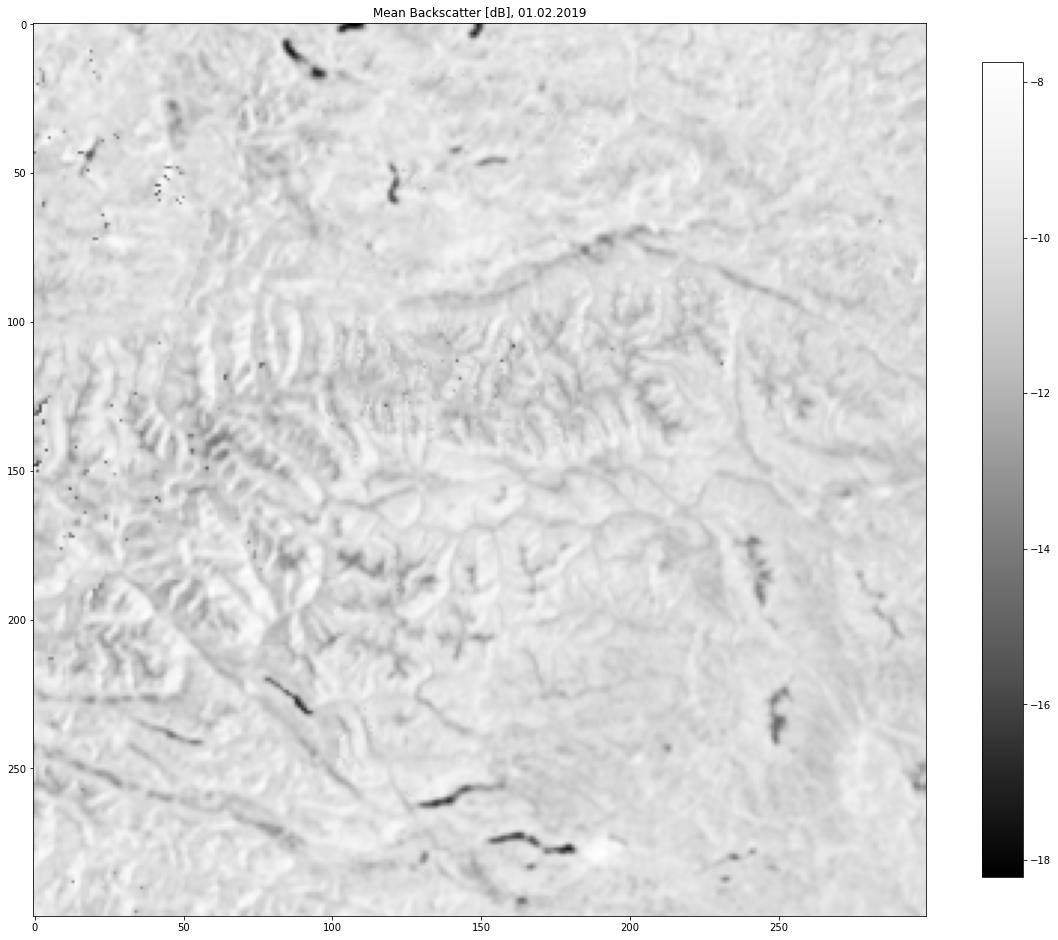

In [20]:
# filter data cube for one day
single_day = vv_cube.filter_by_dimension(datetime(2019, 2, 1, 5, 9, 43), name='datetime_1')

pixels = single_day.load_by_pixels(400, 400, row_size=300, col_size=300, dtype="numpy")

# plot the data
plt.figure(figsize=(20, 20))
plt.title('Mean Backscatter [dB], 01.02.2019')
img_h = plt.imshow(pixels[0, ...] / 100.0, cmap=plt.get_cmap("Greys_r"))
cb = plt.colorbar(img_h, shrink=0.75)
plt.show()